In [ ]:
!python --version
!date

Python 3.11.12
Thu May 22 05:06:09 AM UTC 2025


# JGLUE（日本語言語理解ベンチマーク） + word2vec編

## 前提
- [report4_preprocessing.ipynb](./report4_preprocessing.ipynb)を実行すると前処理された3つのpklファイル（preprocessed_{train,val,test}.pkl）が作成される。この3つのファイルをPCにダウンロードしておき、本コードを実行する環境で参照できるようにアップロードすること。
- `utils.py` も別途アップロードすること。

In [ ]:
from utils import *

# 前処理済みデータ読み込み
df_train = get_data("preprocessed_train.pkl")
df_val = get_data("preprocessed_val.pkl")
df_test = get_data("preprocessed_test.pkl")

# 中身の確認
df_train.head()

,sent1,sent2,bow,w2v,label
0,二人の男性がジャンボジェット機を見ています。,2人の男性が、白い飛行機を眺めています。,二人 の 男性 が ジャンボジェット 機 を 見 て い ます 。 [SEP] 2人 の 男...,"[0.050462592, -0.13604076, 0.010860913, -0.197...",2
1,2人の男性が、白い飛行機を眺めています。,二人の男性がジャンボジェット機を見ています。,2人 の 男性 が 、 白い 飛行機 を 眺め て い ます 。 [SEP] 二人 の 男性...,"[0.088041924, -0.08648207, 0.014981923, -0.196...",2
2,男性が子供を抱き上げて立っています。,坊主頭の男性が子供を抱いて立っています。,男性 が 子供 を 抱き上げ て 立っ て い ます 。 [SEP] 坊主頭 の 男性 が ...,"[0.056786165, -0.1304283, 0.013041455, -0.1172...",2
3,坊主頭の男性が子供を抱いて立っています。,男性が子供を抱き上げて立っています。,坊主頭 の 男性 が 子供 を 抱い て 立っ て い ます 。 [SEP] 男性 が 子供...,"[0.042833548, -0.12648883, 0.002992845, -0.119...",0
4,草地の上で牛と男性が立っています。,農場で白い牛が男性の隣に立っています。,草地 の 上 で 牛 と 男性 が 立っ て い ます 。 [SEP] 農場 で 白い 牛 ...,"[0.13754506, -0.074033, 0.013317642, -0.165398...",2


In [ ]:
# データセット毎のラベル分布チェック

import collections
print("train_labels: ", collections.Counter(df_train["label"]))
print("val_labels: ", collections.Counter(df_val["label"]))
print("test_labels: ", collections.Counter(df_test["label"]))

train_labels:  Counter({2: 11193, 1: 6004, 0: 2876})
val_labels:  Counter({2: 1350, 1: 735, 0: 349})
test_labels:  Counter({2: 1365, 1: 776, 0: 367})


## case 2: word2vec平均 + MLP
やや工夫した実装例として、spacy(ja_ginza) による分散ベクトルを用いた分類器も構築してみた。学習器はMLPclassifier（1層、ユニット数128）のシンプルなNNを用いている。
- (1) 前提文、仮説文をトークンに分け、それぞれの分散ベクトルを取得。
- (2) 全トークンの分散ベクトルから平均ベクトルを求める。これを特徴ベクトルとする。
- (3) MLPで学習。

基本的には case 1 と同じ実装だが、dfに保存しているベクトルが文字列として認識されてしまうため、リストに変換（to_list()）した上で利用している点に注意してください。

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


=== word2vec平均 + MLP ===
               precision    recall  f1-score   support

   entailment       0.55      0.06      0.10       367
contradiction       0.57      0.40      0.47       776
      neutral       0.61      0.86      0.71      1365

     accuracy                           0.60      2508
    macro avg       0.58      0.44      0.43      2508
 weighted avg       0.59      0.60      0.55      2508



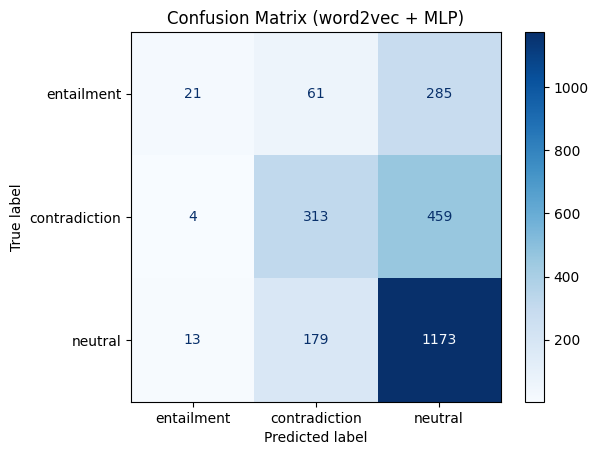

In [ ]:
# ===============================
# ✅ 2. word2vec平均 + MLP
# ===============================
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(128,), max_iter=10)
mlp.fit(df_train["w2v"].to_list(), df_train["label"]) # to_listで与える
pred_w2v = mlp.predict(df_test["w2v"].to_list())      # to_listで与える

print("=== word2vec平均 + MLP ===")
print(classification_report(df_test["label"],
                            pred_w2v,
                            target_names=label2id.keys()))
plot_confusion("word2vec + MLP",
               df_test["label"],
               pred_w2v,
               labels=list(label2id.keys()))

In [ ]:
# 検証データに対する失敗事例分析
pred_w2v = mlp.predict(df_val["w2v"].to_list())
mis_df, mis_all_df = show_misclassified_examples(
    df_val["sent1"], df_val["sent2"], df_val["label"], pred_w2v, id2label
)

mis_df

,sent1,sent2,true_label,pred_label,true_label_name,pred_label_name
0,二つの白いさらにはグリーンピースと細切れの野菜があり、その向こうには渋い顔をした子供が座って...,野菜の入った容器の前で子供がしかめっ面をしています。,0,2,entailment,neutral
1,黄色と赤の電車がホームに停車しているところです。,カラフルな電車が駅のホームに止まっています。,0,2,entailment,neutral
2,青いTシャツを着た男の子が砂浜でフリスビーを投げています。,青い服を着た子供がフリスビーを投げています。,0,1,entailment,contradiction
3,来週、路上の手前に白い消火栓ができる予定です。,路上の手前に白い消火栓が建っています。,1,2,contradiction,neutral
4,大型タンカーの浮かぶ海で、カモメが大きく翼を広げ、飛んでいます。,クルーザーの浮かぶ湖で、サギが大きく翼を広げ、飛んでいます。,1,2,contradiction,neutral
5,オレンジ色の服を着た人が、テニスラケットを持っています。,オレンジ色の服を着た人が、テニスラケットを捨てています。,1,2,contradiction,neutral
6,ソファに座る二人の男性の隣で男性がテレビゲームをしています。,ソファーに二人が座り一人は立っています。,2,1,neutral,contradiction
7,海でサーフィンをしている人がいます。,海でサーフィンをしている男性がいます。,2,1,neutral,contradiction
8,老婆と若い娘がキッチンに並んで立っています。,二人の人がフライパンの中を見ています。,2,1,neutral,contradiction


In [ ]:
# 検証データに対する全失敗事例をExcelファイルとして出力

true_label = df_val["label"].map(id2label)
pred_label = pd.Series(pred_w2v).map(id2label)

mis_all_df = pd.DataFrame({
    "sent1":df_val["sent1"],
    "sent2":df_val["sent2"],
    "true_label":df_val["label"],
    "w2v_pred_label":pred_w2v,
    "true_label_name":true_label,
    "w2v_pred_label_name":pred_label
})

mis_all_df.to_excel("mis_all_df_word2vec.xlsx")